This notebook tests the web scraping code.

In [1]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import nltk
from nltk.corpus import stopwords
import re
from urllib.robotparser import RobotFileParser
from urllib.parse import urljoin, urldefrag, urlparse
from collections import deque
import time
import networkx as nx
import matplotlib.pyplot as plt

from gensim.models.ldamodel import LdaModel
from gensim import corpora

In [2]:

# Ensure NLTK stopwords are downloaded
# Uncomment the following line if you haven't downloaded stopwords yet
# nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

In [3]:
# Helper function to clean text
def clean_text(text):
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Join words back into a single string
    cleaned_text = ' '.join(words)
    return cleaned_text

This function returns a dictionary and a graph. The dictionary has the website URL as the keys and the values are lists of length 2. The first item in the list is the website title, the second is the text content of the website. 

In [4]:
def crawl_website(base_url, max_pages=50):
    visited = set()  # Keep track of visited pages
    to_visit = deque([base_url])  # Efficient queue of pages to visit
    to_visit_set = set([base_url])  # Set for quick lookup to avoid duplicates

    scraped_content = {}  # Dictionary to store {URL: [title, text]}
    graph = nx.DiGraph()  # Initialize the graph

    # Normalize base_url
    parsed_base = urlparse(base_url)
    base_netloc = parsed_base.netloc
    base_scheme = parsed_base.scheme
    base_url = f"{base_scheme}://{base_netloc}"

    # Initialize the robots.txt parser
    robot_parser = RobotFileParser()
    robot_parser.set_url(urljoin(base_url, '/robots.txt'))
    try:
        robot_parser.read()
    except Exception as e:
        print(f"Error reading robots.txt: {e}")
        return scraped_content, graph

    # Get the crawl-delay (if any)
    crawl_delay = robot_parser.crawl_delay('*') or 0

    session = requests.Session()  # Use a session for connection pooling
    session.headers.update({'User-Agent': 'MyCrawler/1.0'})

    while to_visit and len(visited) < max_pages:
        url = to_visit.popleft()
        to_visit_set.remove(url)

        # Remove URL fragments (like #section1) to avoid duplicate pages
        url, _ = urldefrag(url)

        if url in visited or not url.startswith(base_url):
            continue

        # Check if the URL is allowed to be crawled based on robots.txt
        if not robot_parser.can_fetch('*', url):
            print(f"Skipping {url} due to robots.txt restrictions.")
            continue

        try:
            response = session.get(url, timeout=10)
            if response.status_code != 200:
                continue

            # Set the correct encoding
            response.encoding = response.apparent_encoding

            # Mark this URL as visited
            visited.add(url)

            # Parse the HTML content
            soup = BeautifulSoup(response.text, 'html.parser')

            # Add this page as a node in the graph
            graph.add_node(url)

            # Debugging: Print the current URL
            print(f"Visiting: {url}")

            # Extract all links on the page
            for link in soup.find_all('a', href=True):
                raw_link = link['href']
                # Skip empty and anchor-only links
                if not raw_link or raw_link.startswith('#'):
                    continue

                # Create a full URL using urljoin
                full_url = urljoin(url, raw_link)  # Use current url as base

                # Remove URL fragments
                full_url, _ = urldefrag(full_url)

                # Normalize URL to avoid duplicates
                parsed_full_url = urlparse(full_url)
                normalized_full_url = parsed_full_url._replace(
                    params='', query='', fragment=''
                ).geturl()

                # Ensure the URL is within the same domain
                if (
                    parsed_full_url.scheme in ['http', 'https'] and
                    parsed_full_url.netloc == base_netloc and
                    normalized_full_url not in visited and
                    normalized_full_url not in to_visit_set
                ):
                    to_visit.append(normalized_full_url)
                    to_visit_set.add(normalized_full_url)
                    graph.add_edge(url, normalized_full_url)  # Add directed edge

            # Extract and clean text content
            page_text = soup.get_text(separator=' ')
            cleaned_text = clean_text(page_text)

            # Extract the page title
            page_title = soup.title.string.strip() if soup.title else 'No Title'

            # Store the content in the dictionary
            scraped_content[url] = [page_title, cleaned_text]

            # Respect crawl-delay
            if crawl_delay > 0:
                time.sleep(crawl_delay)

        except requests.RequestException as e:
            print(f"Error accessing {url}: {e}")
            continue

    return scraped_content, graph


In [5]:
scraped_content, graph = crawl_website(base_url= 'https://www.churchofjesuschrist.org/?lang=eng', max_pages=5)

Visiting: https://www.churchofjesuschrist.org/?lang=eng
Visiting: https://www.churchofjesuschrist.org/welcome/what-do-latter-day-saints-believe
Visiting: https://www.churchofjesuschrist.org/welcome/savior-jesus-christ
Visiting: https://www.churchofjesuschrist.org/welcome/life-has-purpose
Visiting: https://www.churchofjesuschrist.org/welcome/jesus-knows-you


In [6]:
def visualize_graph(graph, scraped_content, node_name='url'):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, k=0.5, iterations=50)

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color='skyblue')

    # Draw edges
    nx.draw_networkx_edges(
        graph, pos,
        arrowstyle='->',
        arrowsize=20,
        edge_color='gray',
        connectionstyle='arc3, rad=0.1'
    )

    # Prepare node labels based on node_name
    if node_name == 'title':
        # Use the page title as the node label
        labels = {node: scraped_content.get(node, ['No Title'])[0] for node in graph.nodes()}
    else:
        # Use the URL as the node label
        labels = {node: node for node in graph.nodes()}

    # Draw node labels
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8, font_family='sans-serif')

    # Set title and remove axes
    plt.title("Crawled Website Link Structure")
    plt.axis('off')

    # Display the graph
    plt.show()


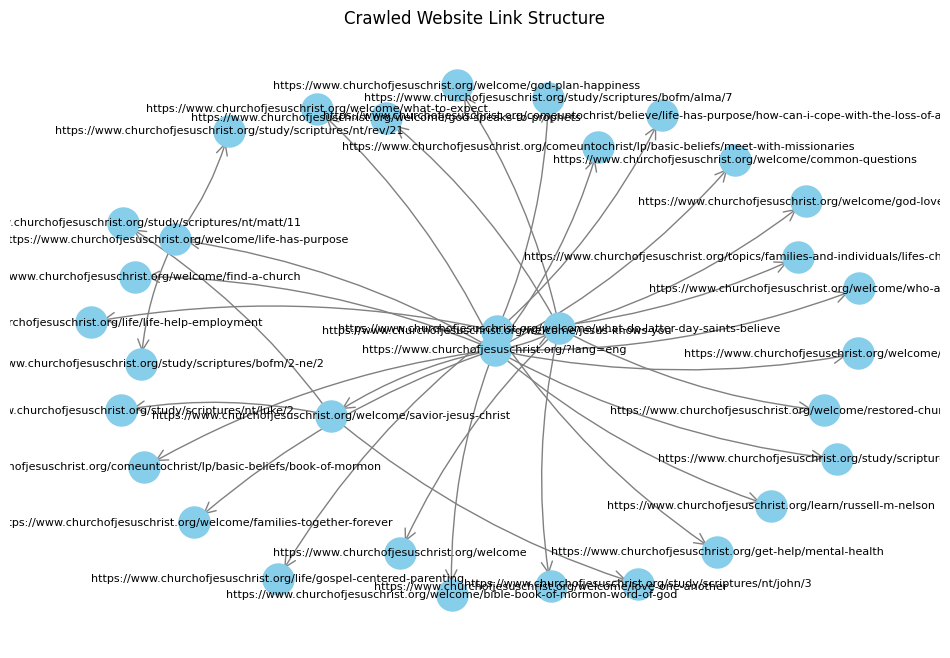

In [7]:
visualize_graph(graph, scraped_content, node_name='url')


Right now titles are not scraped from linked pages

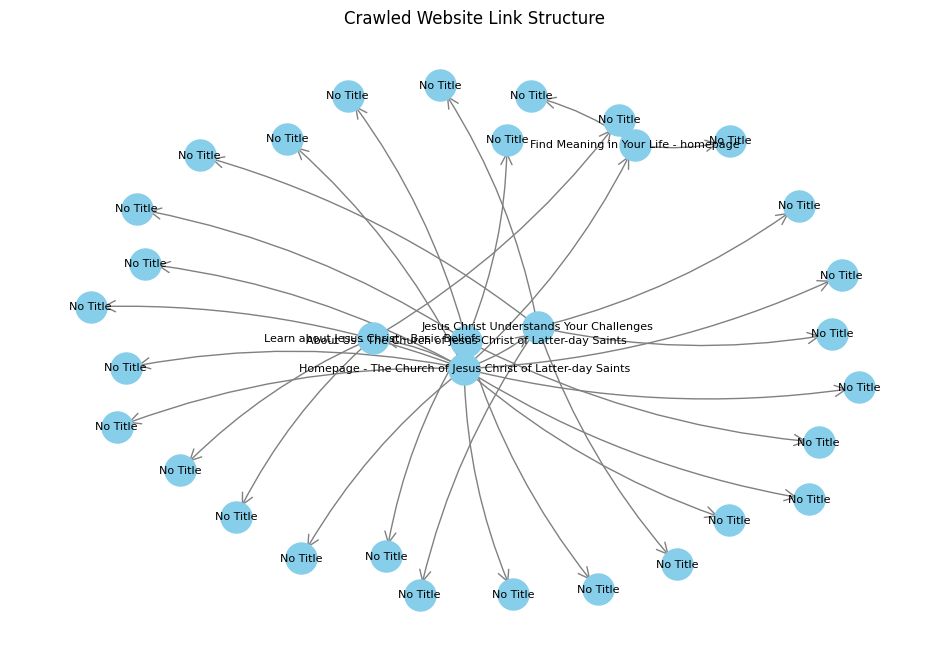

In [8]:
visualize_graph(graph, scraped_content, node_name='title')